# Interpret Results of Trained GCN
In this notebook, I'll try to visualize the learning of a trained GCN model. This should involve the following steps:
* Performance Measurements
* Comparison with competing methods
* Relation to node degree

In [1]:
# classics
import numpy as np
import pandas as pd
import random, h5py
import tensorflow as tf


# my tool and sparse stuff for feature extraction
import utils, gcnIO
import sys, os
sys.path.append(os.path.abspath('../GCN'))
from my_gcn import MYGCN
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse import coo_matrix
import scipy.sparse as sp
from scipy import interp

sys.path.append(os.path.abspath('../pagerank'))
import pagerank

# sklearn imports
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from functools import reduce

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import matplotlib.mlab as mlab
import matplotlib_venn
plt.rc('font', family='Times New Roman')

# set options
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sasse/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/sasse/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [32]:
model_dir = '../data/GCN/training/2019_04_24_16_22_23/'

args, data_file = gcnIO.load_hyper_params(model_dir)
data = gcnIO.load_hdf_data(data_file)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.5


Hyper-Parameters read from ../data/GCN/training/2019_04_24_16_22_23/hyper_params.txt
Data comes from ../data/pancancer/IREF_multiomics_mutexonorm_getcganorm.h5
{'loss_mul': 30.0, 'hidden_dims': [50, 100], 'decay': 0.05, 'lr': 0.001, 'data': '../data/pancancer/IREF_multiomics_mutexonorm_getcganorm.h5', 'cv_runs': 10, 'dropout': 0.5, 'epochs': 5000, 'support': 1}


## Predictions
I want to see what the GCN predicts and if those predictions make any sense.

In [33]:
pred_all = []
sets_all = []
no_cv = 0
for cv_dir in os.listdir(model_dir):
    if cv_dir.startswith('cv_'):
        predictions = pd.DataFrame.from_csv(os.path.join(model_dir, cv_dir, 'predictions.tsv'), sep='\t', header=0)
        pred_all.append(predictions)
        y_train_loc, y_test_loc, train_mask_loc, test_mask_loc = gcnIO.read_train_test_sets(os.path.join(model_dir, cv_dir))
        sets_all.append((y_train_loc, y_test_loc, train_mask_loc, test_mask_loc))
        no_cv += 1
print ("Read predictions from {} CV runs".format(no_cv))

Read predictions from 10 CV runs


In [34]:
# get node names
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes['label'] = np.logical_or(np.logical_or(y_train, y_test), y_val)
# construct ensemble data frame
ensemble_predictions = reduce(lambda left,right: pd.merge(left,right,on='Name'), pred_all)
# get the names corrected
ensemble_predictions.columns = ['Name'] + ['Prob_pos_{}'.format(i) for i in range(1, no_cv+1)]
# restore the IDs which were lost during merging (together with the correct order)
ensemble_predictions = nodes.merge(ensemble_predictions, left_on='Name', right_on='Name')
ensemble_predictions.set_index('ID', inplace=True)
# add columns for mean statistics (number predictions, mean prediction, std)
number_cols = [i for i in ensemble_predictions.columns if i.startswith('Prob_pos_')]
ensemble_predictions['Num_Pos'] = (ensemble_predictions[number_cols] > 0.5).sum(axis=1)
ensemble_predictions['Mean_Pred'] = ensemble_predictions[number_cols].mean(axis=1)
ensemble_predictions['Std_Pred'] = ensemble_predictions[number_cols].std(axis=1)
# write to file
predictions = ensemble_predictions.sort_values(by='Mean_Pred', ascending=False)
predictions.to_csv(os.path.join(model_dir, 'ensemble_predictions.tsv'), sep='\t')
predictions.head(20)

,Name,label,Prob_pos_1,Prob_pos_2,Prob_pos_3,Prob_pos_4,Prob_pos_5,Prob_pos_6,Prob_pos_7,Prob_pos_8,Prob_pos_9,Prob_pos_10,Num_Pos,Mean_Pred,Std_Pred
ID,,,,,,,,,,,,,,,
ENSG00000141510,TP53,True,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
ENSG00000168036,CTNNB1,True,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
ENSG00000121879,PIK3CA,True,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
ENSG00000100393,EP300,True,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
ENSG00000145675,PIK3R1,True,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
ENSG00000139687,RB1,True,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
ENSG00000005339,CREBBP,True,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
ENSG00000149311,ATM,True,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000
ENSG00000170027,YWHAG,False,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10,1.000,0.000


In [35]:
predictions = pd.DataFrame.from_csv(os.path.join(model_dir, 'ensemble_predictions.tsv'),
                                    sep='\t', header=0)
nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
nodes = nodes[~nodes.index.duplicated()]
pred_ordered = predictions[~predictions.index.duplicated()]
pred_ordered.reindex(index=nodes.index)

predictions.drop([c for c in predictions.columns if c.startswith('Prob_pos')], axis=1, inplace=True)
predictions.columns = ['Name', 'label', 'Num_Pos', 'Prob_pos', 'Std_Pred']

## Average ROC/PR Curves over the Folds

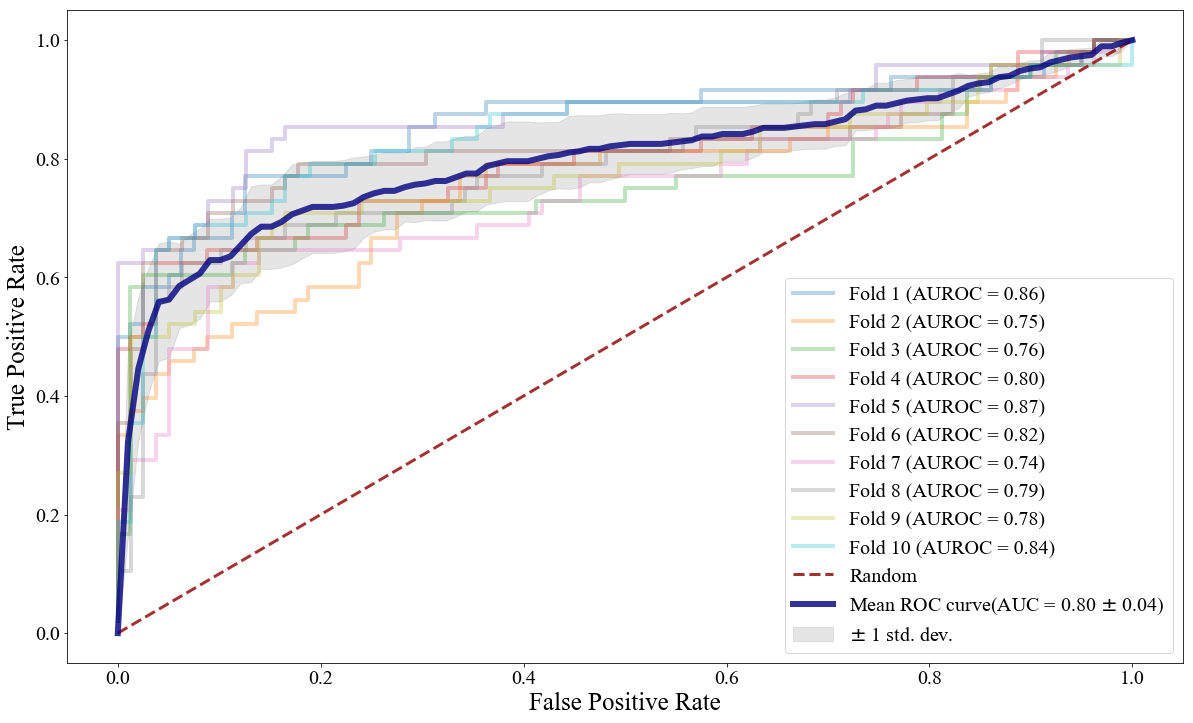

In [36]:
# construct test set statistics
fig = plt.figure(figsize=(20, 12))

k = 1
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for pred in pred_all:
    y_t = sets_all[k-1][1]
    m_t = sets_all[k-1][3]
    fpr, tpr, _ = roc_curve(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    auroc = roc_auc_score(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    aucs.append(auroc)
    plt.plot(fpr, tpr, lw=4, alpha=0.3, label='Fold %d (AUROC = %0.2f)' % (k, auroc))
    k += 1

# plot random line
plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='darkred',
         label='Random', alpha=.8)

# plot mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='navy',
         label=r'Mean ROC curve(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=6, alpha=.8)

# plot std dev
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
#plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right", prop={'size': 20})
plt.tick_params(axis='both', labelsize=20)
fig.savefig(os.path.join(model_dir, 'mean_ROC_curve.svg'))
fig.savefig(os.path.join(model_dir, 'mean_ROC_curve.png'), dpi=300)

1.0 1.0 0.0


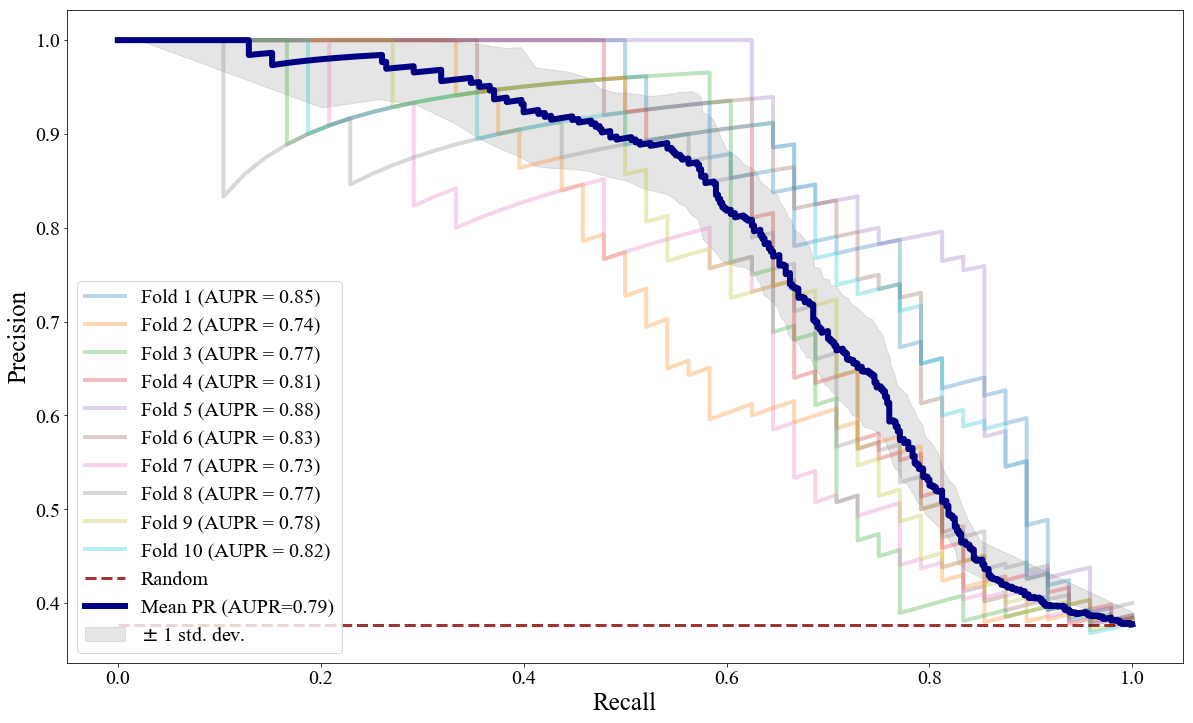

In [37]:
fig = plt.figure(figsize=(20, 12))

k = 1
y_true = []
y_pred = []
pr_values = []
rec_values = []
sample_thresholds = np.linspace(0, 1, 100)
no_pos = []
no_total = []
for pred in pred_all:
    y_t = sets_all[k-1][1] # test labels
    m_t = sets_all[k-1][3] # test mask
    pr, rec, thr = precision_recall_curve(probas_pred=pred[m_t].Prob_pos, y_true=y_t[m_t])
    no_pos.append(y_t.sum())
    no_total.append(m_t.sum())
    pr_values.append(interp(sample_thresholds, thr, pr[:-1]))
    #pr_values[-1][-1] = 1.0
    rec_values.append(interp(sample_thresholds, thr, rec[:-1]))
    aupr = average_precision_score(y_score=pred[m_t].Prob_pos, y_true=y_t[m_t])
    plt.plot(rec, pr, lw=4, alpha=0.3, label='Fold %d (AUPR = %0.2f)' % (k, aupr))
    y_true.append(y_t[m_t])
    y_pred.append(pred[m_t].Prob_pos)
    k += 1

# plot random line
rand_perf = np.mean(no_pos) / np.mean(no_total)
plt.plot([0, 1], [rand_perf, rand_perf], linestyle='--', lw=3, color='darkred',
         label='Random', alpha=.8)

# plot mean curve (PR curve over all folds)
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
mean_precision, mean_recall, mean_thresholds = precision_recall_curve(y_true, y_pred)
label = 'Mean PR (AUPR=%.2f)' % (auc(mean_recall, mean_precision))
plt.plot(mean_recall, mean_precision, label=label, lw=6, color='navy')

# plot std dev
std_pr = np.std(pr_values, axis=0)
mean_pr = np.mean(pr_values, axis=0)
mean_rec = np.mean(rec_values, axis=0)
pr_upper = np.minimum(mean_pr + std_pr, 1)
pr_lower = np.maximum(mean_pr - std_pr, 0)
pr_upper = np.append(pr_upper, 1.)
pr_lower = np.append(pr_lower, 1.)
mean_rec = np.append(mean_rec, 0.)
print (pr_upper[-1], pr_lower[-1], mean_rec[-1])

plt.fill_between(mean_rec, pr_lower, pr_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.tick_params(axis='both', labelsize=20)
plt.xlabel('Recall', fontsize=25)
plt.ylabel('Precision', fontsize=25)
plt.legend(prop={'size':20})
fig.savefig(os.path.join(model_dir, 'mean_PR_curve.svg'))
fig.savefig(os.path.join(model_dir, 'mean_PR_curve.png'), dpi=300)

## Enrich predictions and plot relationship to node degree

In [38]:
features_df = pd.DataFrame(features, index=node_names[:, 0])
features_df['Name'] = node_names[:, 1]
features_df['neighbors'] = network.sum(axis=0)
pred_with_feat = features_df.join(predictions, how='inner', lsuffix='_')
print (pred_with_feat.shape)
pos_predicted = pred_with_feat[pred_with_feat.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID'], axis=1)
labels_df['positive'] = (y_train[:,0] | y_test[:,0] | y_val[:, 0])
labels_df['training_set'] = train_mask
labels_df['testing_set'] = test_mask
labels_df['validation_set'] = val_mask
labels_df['label'] = np.logical_or(train_mask, test_mask, val_mask).astype(int)
labels_df['negative'] = labels_df.label & ~labels_df.positive

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
pos_nofeat = predictions[predictions.Prob_pos >= CLASSIFICATION_THRESHOLD]
pos_nofeat.sort_values(by='Prob_pos', ascending=False).to_csv(os.path.join(model_dir, 'positive_prediction.txt'),
                                                                 sep='\t')

(11418, 55)
Predicted 3415 genes of 12129 total to be involved in infection


Correlation of prediction with #neighbors: 0.3693622888953853
Correlation of prediction with #neighbors for positives: 0.32055978204744845


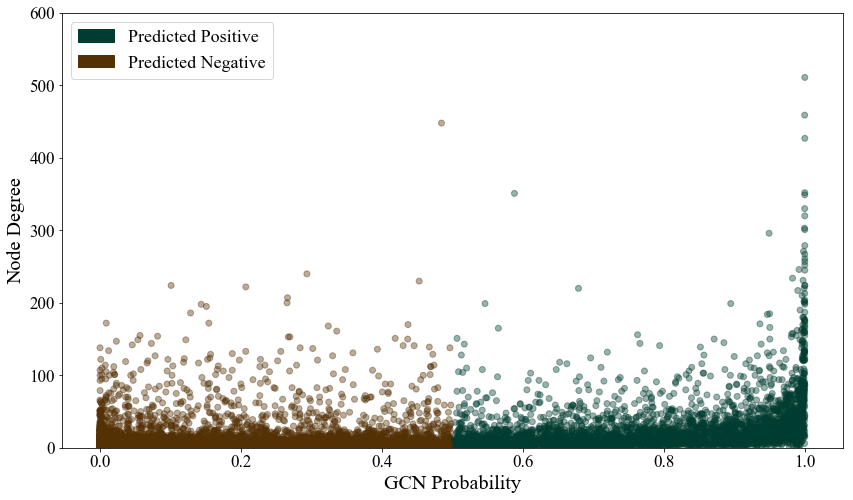

In [39]:
fig = plt.figure(figsize=(14, 8))
cmap = plt.cm.BrBG
plt.scatter(pred_with_feat.Prob_pos, pred_with_feat.neighbors,
            c=pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD,
            cmap=cmap, alpha=.4)
plt.gca().set_ylim([0, 600])
plt.xlabel('GCN Probability', fontsize=20)
plt.ylabel('Node Degree', fontsize=20)
plt.tick_params(axis='both', labelsize=17)
pred = mpatches.Patch(color=cmap(1000), label='Predicted Positive')
non_pred = mpatches.Patch(color=cmap(0), label='Predicted Negative')
plt.legend(handles=[pred, non_pred], loc='upper left', prop={'size': 18})
fig.savefig(os.path.join(model_dir, 'degree_correlation.png'), dpi=300)

df_pos = pred_with_feat[pred_with_feat.Prob_pos >= CLASSIFICATION_THRESHOLD]
print ("Correlation of prediction with #neighbors: {}".format(pred_with_feat.Prob_pos.corr(pred_with_feat.neighbors)))
print ("Correlation of prediction with #neighbors for positives: {}".format(df_pos.Prob_pos.corr(df_pos.neighbors)))

In [40]:
labels_with_pred = labels_df.join(predictions, lsuffix='_', how='inner')
predictions_for_pos = labels_with_pred[labels_with_pred.positive == 1]
true_positives = predictions_for_pos[predictions_for_pos.Prob_pos > CLASSIFICATION_THRESHOLD]
no_tp = true_positives.shape[0]
no_positives = predictions_for_pos.shape[0]
pred_pos_test = true_positives[true_positives.testing_set == 1]
pred_pos_train = true_positives[true_positives.training_set == 1]
predictions_for_neg = labels_with_pred[labels_with_pred.negative == 1]
true_negatives = predictions_for_neg[predictions_for_neg.Prob_pos <= CLASSIFICATION_THRESHOLD]
no_tn = true_negatives.shape[0]
no_fn = predictions_for_neg[predictions_for_neg.Prob_pos > CLASSIFICATION_THRESHOLD].shape[0]

print ("Predicted {} out of {} known infection genes".format(no_tp, no_positives)
      )
print ("Out of these {}, {} were not shown during training.".format(no_positives,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(pred_pos_test.shape[0],
                                                        y_test[:,0].sum(),
                                                        pred_pos_test.shape[0]/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(pred_pos_train.shape[0],
                                                         y_train[:,0].sum(),
                                                         pred_pos_train.shape[0]/y_train[:,0].sum()*100.)
      )
print ("Correctly rejected {} out of {} genes (True Negatives) ({}%)".format(no_tn,
                                                                     predictions_for_neg.shape[0],
                                                                     no_tn/predictions_for_neg.shape[0]*100.))
print ("Falsely predicted {} negatives (FN)".format(no_fn))
predictions_for_neg.sort_values(by='Prob_pos', ascending=False).head(20)

Predicted 466 out of 637 known infection genes
Out of these 637, 160 were not shown during training.
Predicted 95 out of 160 test genes (59.375%)
Predicted 333 out of 432 train genes (77.08333333333334%)
Correctly rejected 613 out of 714 genes (True Negatives) (85.85434173669468%)
Falsely predicted 101 negatives (FN)


,Name_,positive,training_set,testing_set,validation_set,label_,negative,Name,label,Num_Pos,Prob_pos,Std_Pred
ENSG00000120693,SMAD9,False,False,True,False,1,True,SMAD9,False,10,0.999,0.001
ENSG00000089902,RCOR1,False,False,True,False,1,True,RCOR1,False,10,0.986,0.005
ENSG00000052126,PLEKHA5,False,True,False,False,1,True,PLEKHA5,False,10,0.984,0.019
ENSG00000107854,TNKS2,False,True,False,False,1,True,TNKS2,False,10,0.974,0.007
ENSG00000115750,TAF1B,False,True,False,False,1,True,TAF1B,False,10,0.966,0.014
ENSG00000105963,ADAP1,False,True,False,False,1,True,ADAP1,False,10,0.960,0.016
ENSG00000152467,ZSCAN1,False,True,False,False,1,True,ZSCAN1,False,10,0.959,0.023
ENSG00000078967,UBE2D4,False,True,False,False,1,True,UBE2D4,False,10,0.952,0.057
ENSG00000154832,CXXC1,False,True,False,False,1,True,CXXC1,False,10,0.939,0.025
ENSG00000116213,WRAP73,False,True,False,False,1,True,WRAP73,False,10,0.935,0.036


In [41]:
histone_gene_classification = labels_with_pred[labels_with_pred.Name.str.contains('HIST')].sort_values(by='Prob_pos',
                                                                                                         ascending=False).head(10)
histone_gene_classification[['Name', 'positive', 'negative', 'Num_Pos', 'Prob_pos', 'Std_Pred']]

,Name,positive,negative,Num_Pos,Prob_pos,Std_Pred
ENSG00000277775,HIST1H3F,False,False,10,1.000,0.000
ENSG00000184678,HIST2H2BE,False,False,10,0.974,0.025
ENSG00000285435,HIST3H3,False,False,10,0.963,0.055
ENSG00000124610,HIST1H1A,False,False,10,0.916,0.087
ENSG00000183598,HIST2H3D,False,True,9,0.906,0.237
ENSG00000187837,HIST1H1C,False,False,9,0.881,0.230
ENSG00000184260,HIST2H2AC,False,False,10,0.840,0.127
ENSG00000184357,HIST1H1B,False,False,9,0.757,0.271
ENSG00000270276,HIST2H4B,False,True,7,0.679,0.324
ENSG00000278463,HIST1H2AB,False,False,8,0.646,0.318


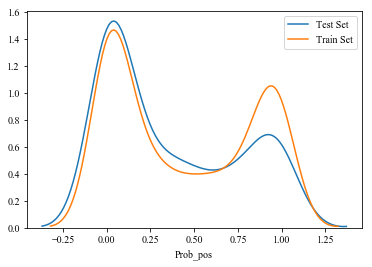

In [42]:
seaborn.distplot(labels_with_pred[labels_with_pred.testing_set].Prob_pos, hist=False, label='Test Set')
seaborn.distplot(labels_with_pred[labels_with_pred.training_set].Prob_pos, hist=False, label='Train Set')

In [43]:
y_true = y_test[test_mask == 1, 0]
y_score = predictions[test_mask == 1].Prob_pos
accuracy_score(y_pred=y_score > 0.5, y_true=y_true)

0.5011764705882353

In [44]:
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

In [45]:
[i for i in known_cancer_genes if i.startswith('HIST')]

['HIST1H3B', 'HIST1H4I']

## Train other Classifiers on the Features for Comparison
In order to evaluate our method, let's compare it's power to other algorithms. For now, I'll focus on ones, that operate on the features alone and algorithms that operate on the network alone.
The comparison is with:
* **SVM classifier**: A very powerful, non-linear method that generally does not really overfit and can deal with little data. This should be an upper bound on what one can reach on the features alone.
* **Logistic regression**: This is a linear algorithm, also only operating on the features. It is less powerful than an SVM.
* **PageRank**: A network ranking method that only computes the most important nodeso in the network. It's completely blind to the features.

In [46]:
X_train = features[train_mask.astype(np.bool)]
y_train_svm = y_train[train_mask.astype(np.bool)]

X_test = features[test_mask.astype(np.bool)]
y_test_svm = y_test[test_mask.astype(np.bool)]

In [47]:
# train random forest on the features only and predict for test set and all genes
rf = RandomForestClassifier()
rf.fit(X_train, y_train_svm.reshape(-1))
pred_rf = rf.predict_proba(X_test)
print ("Number of predicted genes in Test set (RF): {}".format(pred_rf.argmax(axis=1).sum()))
pred_rf_all = rf.predict_proba(features)
print ("RF predicts {} genes in total".format(np.argmax(pred_rf_all, axis=1).sum()))

Number of predicted genes in Test set (RF): 127
RF predicts 3682 genes in total


In [48]:
# train logistic regression on the features only and predict for test set and all genes
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train, y_train_svm.reshape(-1))
pred_lr = logreg.predict_proba(X_test)
print ("Number of predicted genes in Test set (LogReg): {}".format(pred_lr.argmax(axis=1).sum()))
pred_lr_all = logreg.predict_proba(features)
print ("LogReg predicts {} genes in total".format(np.argmax(pred_lr_all, axis=1).sum()))

Number of predicted genes in Test set (LogReg): 157
LogReg predicts 4678 genes in total


In [49]:
# train pagerank on the network
scores, names = pagerank.pagerank(network, node_names)
pr_df = pd.DataFrame(scores, columns=['Number', 'Score'])
names = pd.DataFrame(names, columns=['ID', 'Name'])
pr_pred_all = pr_df.join(names, on='Number', how='inner')
pr_pred_all.drop_duplicates(subset='Name', inplace=True)

# make them have the same order as node names for easy indexing from test set
node_names_df = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
pr_pred_all = pr_pred_all.set_index('Name').reindex(node_names_df.Name)
pr_pred_test = pr_pred_all[pr_pred_all.index.isin(node_names[test_mask == 1, 1])]
pr_pred_test.drop_duplicates(inplace=True)

Maximum Pagerank: Index: 11270	Pagerank: 0.006650312418214648
Minimum Pagerank: Index: 3508	Pagerank: 1.503088157884692e-05


/pkg/python-3.6.0-0/lib/python3.6/site-packages/pandas/util/decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [50]:
# do a random walk with restart and use HotNet2 heat as p_0

# read heat json from file
heat_df = pd.read_json('../../hotnet2/heat_syn_cnasnv.json').drop('parameters', axis=1)
heat_df.dropna(axis=0, inplace=True)

# join with node names to get correct order and only genes present in network
nn = pd.DataFrame(node_names, columns=['ID', 'Name'])
heat_df = nn.merge(heat_df, left_on='Name', right_index=True, how='left')
heat_df.fillna(0, inplace=True)

# add normalized heat
heat_df['heat_norm'] = heat_df.heat / heat_df.heat.sum()

p_0 = heat_df.heat_norm
#p_0 = features.mean(axis=1)

In [51]:
beta = 0.3
W = network / network.sum(axis=0) # normalize A
assert (np.allclose(W.sum(axis=0), 1)) # assert that rows/cols sum to 1

p = np.linalg.inv(beta * (np.eye(network.shape[0]) - (1 - beta) * W)).dot(np.array(p_0))
rwr_ranks = np.argsort(p)[::-1]
heat_df['rwr_score'] = p
rwr_pred_test = heat_df[test_mask == 1].rwr_score

ACCURACY: 0.52


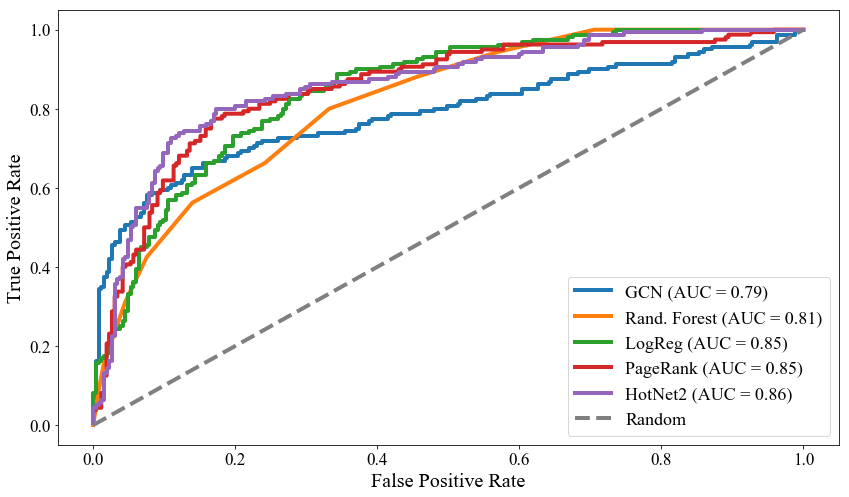

In [52]:
linewidth = 4
labelfontsize = 20
ticksize = 17
#y_score = predictions.Prob_pos
#y_true = np.logical_or(y_train, y_test)
y_true = y_test[test_mask == 1, 0]
pred_testset_gcn = predictions[predictions.Name.isin(node_names[test_mask, 1])]
y_true_gcn = pred_testset_gcn.label
y_score = pred_testset_gcn.Prob_pos
fpr, tpr, thresholds = roc_curve(y_true=y_true_gcn, y_score=y_score)
roc_auc = roc_auc_score(y_true=y_true_gcn, y_score=y_score)

# compute roc for random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true=y_true, y_score=pred_rf[:, 1])
roc_auc_rf = roc_auc_score(y_true=y_true, y_score=pred_rf[:, 1])

# compute ROC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_true=y_true, y_score=pred_lr[:, 1])
roc_auc_lr = roc_auc_score(y_true=y_true, y_score=pred_lr[:, 1])

# compute ROC for PageRank
fpr_pr, tpr_pr, thresholds_pr = roc_curve(y_true=y_true, y_score=pr_pred_test.Score)
roc_auc_pr = roc_auc_score(y_true=y_true, y_score=pr_pred_test.Score)

# compute ROC for RWR with HotNet2 heat scores
fpr_hotnet, tpr_hotnet, thresholds_hotnet = roc_curve(y_true=y_true, y_score=rwr_pred_test)
roc_auc_hotnet = roc_auc_score(y_true=y_true, y_score=rwr_pred_test)

# plot ROC curve
fig = plt.figure(figsize=(14, 8))
plt.plot(fpr, tpr, lw=linewidth, label='GCN (AUC = {0:.2f})'.format(roc_auc))
plt.plot(fpr_rf, tpr_rf, lw=linewidth, label='Rand. Forest (AUC = {0:.2f})'.format(roc_auc_rf))
plt.plot(fpr_lr, tpr_lr, lw=linewidth, label='LogReg (AUC = {0:.2f})'.format(roc_auc_lr))
plt.plot(fpr_pr, tpr_pr, lw=linewidth, label='PageRank (AUC = {0:.2f})'.format(roc_auc_pr))
plt.plot(fpr_hotnet, tpr_hotnet, lw=linewidth, label='HotNet2 (AUC = {0:.2f})'.format(roc_auc_hotnet))
plt.plot([0, 1], [0, 1], color='gray', lw=linewidth, linestyle='--', label='Random')
plt.xlabel('False Positive Rate', fontsize=labelfontsize)
plt.ylabel('True Positive Rate', fontsize=labelfontsize)
plt.tick_params(axis='both', labelsize=ticksize)
#plt.title('ROC Curve')
plt.legend(loc='lower right', prop={'size': 18})
fig.savefig(os.path.join(model_dir, 'roc_curve.svg'))
acc = accuracy_score(y_true=y_true,
                     y_pred=y_score >= CLASSIFICATION_THRESHOLD)
print ("ACCURACY: {}".format(acc))

In [53]:
distances = np.sqrt(np.sum((np.array([0, 1]) - np.array([fpr, tpr]).T)**2, axis=1))
idx = np.argmin(distances)
best_threshold = thresholds[idx]
print ("Optimal classification threshold: {}".format(best_threshold))

BEST_THRESHOLD = best_threshold

Optimal classification threshold: 0.25388528902549296


0.3764705882352941 160 265


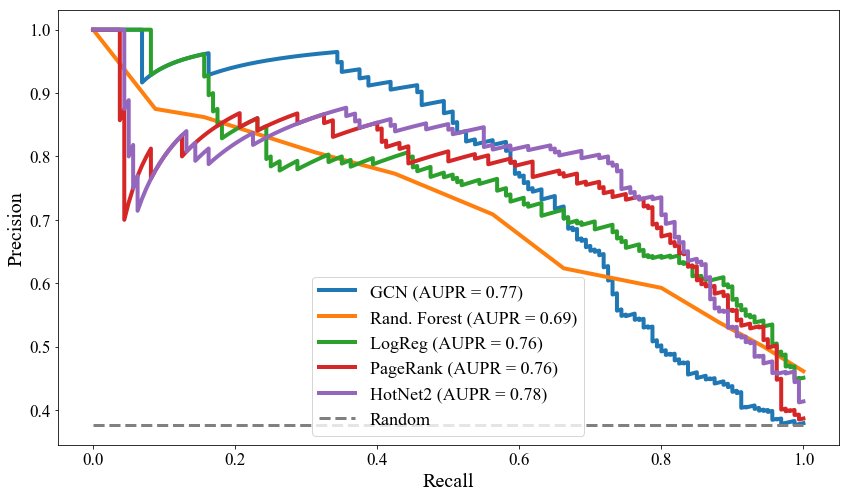

In [54]:
linewidth = 4
labelfontsize = 20
ticksize = 17
# calculate precision and recall for GCN
pr, rec, thresholds = precision_recall_curve(y_true=y_true_gcn, probas_pred=y_score)
aupr = average_precision_score(y_true=y_true_gcn, y_score=y_score)

# calculate precision and recall for RF
pr_rf, rec_rf, thresholds_rf = precision_recall_curve(y_true=y_true, probas_pred=pred_rf[:, 1])
aupr_rf = average_precision_score(y_true=y_true, y_score=pred_rf[:, 1])

# calculate precision and recall for Logistic Regression
pr_lr, rec_lr, thresholds_lr = precision_recall_curve(y_true=y_true, probas_pred=pred_lr[:, 1])
aupr_lr = average_precision_score(y_true=y_true, y_score=pred_lr[:, 1])

# calculate precision and recall for PageRank
pr_pr, rec_pr, thresholds_pr = precision_recall_curve(y_true=y_true, probas_pred=pr_pred_test.Score)
aupr_pr = average_precision_score(y_true=y_true, y_score=pr_pred_test.Score)

# calculate precision and recall for Hotnet2
pr_hotnet, rec_hotnet, thresholds_hotnet = precision_recall_curve(y_true=y_true, probas_pred=rwr_pred_test)
aupr_hotnet = average_precision_score(y_true=y_true, y_score=rwr_pred_test)

fig = plt.figure(figsize=(14, 8))
plt.plot(rec, pr, lw=linewidth, label='GCN (AUPR = {0:.2f})'.format(aupr))
#plt.plot(rec_svm, pr_svm, lw=linewidth, label='SVM (AUPR = {0:.2f})'.format(aupr_svm))
plt.plot(rec_rf, pr_rf, lw=linewidth, label='Rand. Forest (AUPR = {0:.2f})'.format(aupr_rf))
plt.plot(rec_lr, pr_lr, lw=linewidth, label='LogReg (AUPR = {0:.2f})'.format(aupr_lr))
plt.plot(rec_pr, pr_pr, lw=linewidth, label='PageRank (AUPR = {0:.2f})'.format(aupr_pr))
plt.plot(rec_hotnet, pr_hotnet, lw=linewidth, label='HotNet2 (AUPR = {0:.2f})'.format(aupr_hotnet))
random_y = y_true.sum() / (y_true.sum() + y_true.shape[0] - y_true.sum())
print (random_y, y_true.sum(), y_true.shape[0]-y_true.sum())
plt.plot([0, 1], [random_y, random_y], color='gray', lw=3, linestyle='--', label='Random')
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.tick_params(axis='both', labelsize=ticksize)
#plt.title('Precision-Recall Curve')
plt.legend(prop={'size': 18})
fig.savefig(os.path.join(model_dir, 'prec_recall.svg'))
fig.savefig(os.path.join(model_dir, 'prec_recall.png'), dpi=300)
#pr, rec

In [55]:
distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([rec, pr]).T)**2, axis=1))
idx = np.argmin(distances)
best_threshold = thresholds[idx]
print ("Optimal classification threshold: {}".format(best_threshold))

BEST_THRESHOLD = best_threshold


Optimal classification threshold: 0.42960597202181816


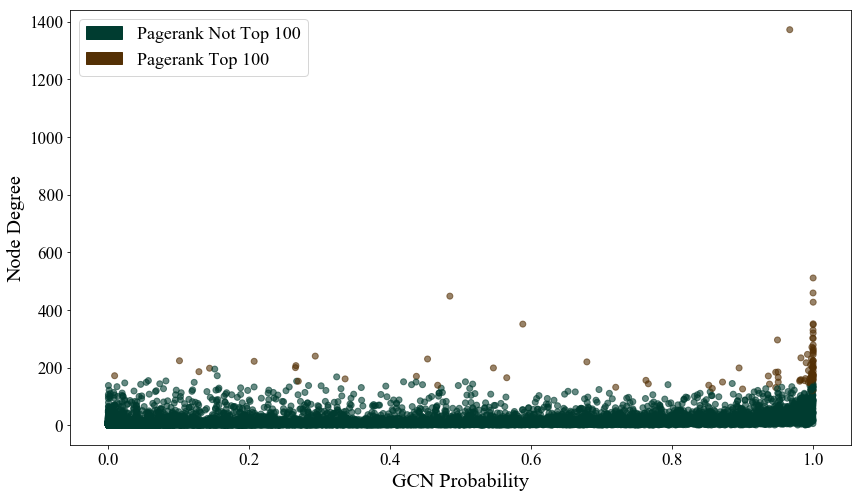

In [57]:
TOP_N_PR = 100

# integrate pagerank scores
pred_with_pr_score = pred_with_feat.join(pr_pred_all.drop('ID', axis=1), on='Name')
pred_with_pr_score = pred_with_pr_score[~pred_with_pr_score.index.duplicated()]

fig = plt.figure(figsize=(14, 8))
cmap = plt.cm.BrBG
highest_n_pr_cutoff = pred_with_pr_score.sort_values(by='Score', ascending=False).iloc[TOP_N_PR, :].Score
plt.scatter(pred_with_pr_score.Prob_pos, pred_with_pr_score.neighbors,
            c=pred_with_pr_score.Score <= highest_n_pr_cutoff,
            cmap=cmap, alpha=.6)
#plt.gca().set_ylim([0, 900])
plt.xlabel('GCN Probability', fontsize=20)
plt.ylabel('Node Degree', fontsize=20)
plt.tick_params(axis='both', labelsize=17)
non_pred = mpatches.Patch(color=cmap(0), label='Pagerank Top {}'.format(TOP_N_PR))
pred = mpatches.Patch(color=cmap(1000), label='Pagerank Not Top {}'.format(TOP_N_PR))
plt.legend(handles=[pred, non_pred], loc='upper left', prop={'size': 18})
fig.savefig(os.path.join(model_dir, 'corr_degree_gcnpred_prtop{}.png'.format(TOP_N_PR)), dpi=300)

## Compute Overlap with other Datasets

In [58]:
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

remove_blood_cancer_genes = False
if remove_blood_cancer_genes:
    # load cgc
    cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv')
    cgc.dropna(subset=['Tissue Type'], inplace=True)

    # find blood cancer genes based on these abbreviations (E=Epithelial, M=Mesenchymal, O=Other, L=Leukaemia/lymphoma)
    pattern = '|'.join(['E', 'O', 'M', 'E;'])
    non_blood_cancer_genes = cgc[cgc['Tissue Type'].str.contains(pattern)]
    blood_cancer_genes = cgc[~cgc['Tissue Type'].str.contains(pattern)]
    known_cancer_genes_innet = non_blood_cancer_genes[non_blood_cancer_genes['Gene Symbol'].isin(known_cancer_genes_innet)]['Gene Symbol']
    print ("Left with {} known cancer genes after blood removal".format(known_cancer_genes_innet.shape[0]))

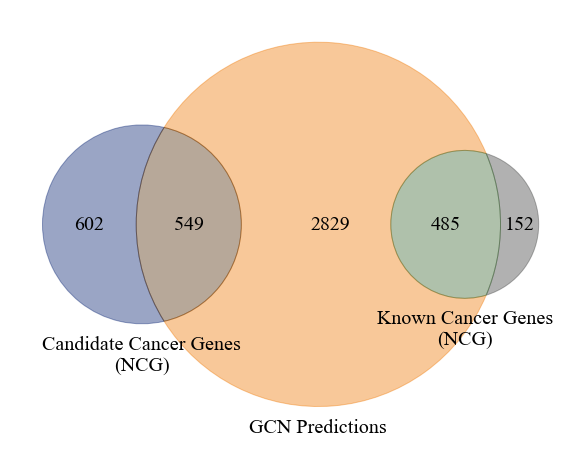

In [59]:
fig = plt.figure(figsize=(14, 8))
v = matplotlib_venn.venn3([set(known_cancer_genes_innet),
                           set(ensemble_predictions[ensemble_predictions.Mean_Pred >= BEST_THRESHOLD].Name),
                           set(candidate_cancer_genes_innet)],
          set_labels=['Known Cancer Genes\n(NCG)', 'GCN Predictions', 'Candidate Cancer Genes\n(NCG)'])
v.get_patch_by_id('10').set_color('#3d3e3d')
v.get_patch_by_id('11').set_color('#37652d')
v.get_patch_by_id('01').set_color('#ee7600')
#v.get_patch_by_id('111').set_color('#890707')
#v.get_patch_by_id('101').set_color('#6E80B7')
v.get_patch_by_id('011').set_color('#4d2600')
v.get_patch_by_id('001').set_color('#031F6F')
v.get_label_by_id('A').set_fontsize(20)
v.get_label_by_id('B').set_fontsize(20)
v.get_label_by_id('C').set_fontsize(20)
v.get_label_by_id('10').set_fontsize(20)
v.get_label_by_id('11').set_fontsize(20)
v.get_label_by_id('01').set_fontsize(20)
#v.get_label_by_id('111').set_fontsize(20)
#v.get_label_by_id('101').set_fontsize(20)
v.get_label_by_id('011').set_fontsize(20)
v.get_label_by_id('001').set_fontsize(20)
fig.savefig(os.path.join(model_dir, 'overlap_NCG.svg'))
fig.savefig(os.path.join(model_dir, 'overlap_NCG.png'), dpi=300)

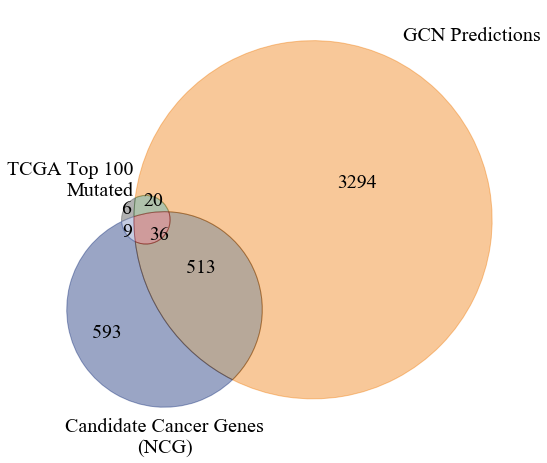

In [60]:
tcga_most_mut = pd.read_csv('../data/pancancer/TCGA/tcga_100_most_mutated_genes.tsv', sep='\t')
tcga_most_mut.drop('Select column', axis=1, inplace=True)
tcga_most_mut.set_index('Symbol', inplace=True)
tcga_most_mut_innet = tcga_most_mut[tcga_most_mut.index.isin(node_names[:, 1])]
fig = plt.figure(figsize=(14, 8))
v = matplotlib_venn.venn3([set(tcga_most_mut_innet.index),
                           set(ensemble_predictions[ensemble_predictions.Mean_Pred >= BEST_THRESHOLD].Name),
                           set(candidate_cancer_genes_innet)],
          set_labels=['TCGA Top 100\nMutated', 'GCN Predictions', 'Candidate Cancer Genes\n(NCG)'])
v.get_patch_by_id('10').set_color('#3d3e3d')
v.get_patch_by_id('11').set_color('#37652d')
v.get_patch_by_id('01').set_color('#ee7600')
v.get_patch_by_id('111').set_color('#890707')
v.get_patch_by_id('101').set_color('#6E80B7')
v.get_patch_by_id('011').set_color('#4d2600')
v.get_patch_by_id('001').set_color('#031F6F')
v.get_label_by_id('A').set_fontsize(20)
v.get_label_by_id('B').set_fontsize(20)
v.get_label_by_id('C').set_fontsize(20)
v.get_label_by_id('10').set_fontsize(20)
v.get_label_by_id('11').set_fontsize(20)
v.get_label_by_id('01').set_fontsize(20)
v.get_label_by_id('111').set_fontsize(20)
v.get_label_by_id('101').set_fontsize(20)
v.get_label_by_id('011').set_fontsize(20)
v.get_label_by_id('001').set_fontsize(20)
fig.savefig(os.path.join(model_dir, 'overlap_TCGA_most_mutated.svg'))
fig.savefig(os.path.join(model_dir, 'overlap_TCGA_most_mutated.png'), dpi=300)

## List of Potential **New** Candidates from GCN

In [61]:
all_ncg_genes = known_cancer_genes + candidate_cancer_genes
not_labeled = ensemble_predictions[~ensemble_predictions.Name.isin(known_cancer_genes)]
cols_of_interest = ['Name', 'label', 'Num_Pos', 'Mean_Pred', 'Std_Pred']
not_labeled[not_labeled.Name.isin(candidate_cancer_genes)].sort_values(by='Mean_Pred', ascending=False)[cols_of_interest].head(10)

,Name,label,Num_Pos,Mean_Pred,Std_Pred
ID,,,,,
ENSG00000155657,TTN,False,10,1.000,0.000
ENSG00000010810,FYN,False,10,1.000,0.000
ENSG00000163554,SPTA1,False,10,1.000,0.000
ENSG00000124788,ATXN1,False,10,1.000,0.000
ENSG00000177885,GRB2,False,10,1.000,0.000
ENSG00000169375,SIN3A,False,10,1.000,0.000
ENSG00000171681,ATF7IP,False,10,1.000,0.000
ENSG00000196591,HDAC2,False,10,1.000,0.000
ENSG00000123384,LRP1,False,10,1.000,0.001
